# Classification

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score,confusion_matrix,classification_report)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.svm import SVC
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif

from autogluon.tabular import TabularPredictor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns

pd.set_option('display.max_rows', 500)

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import datasets
df_patient = pd.read_excel('data/Descriptif_patients_modified.xlsx')
init_df_radiomics_multislices = pd.read_excel('data/radiomiques_multislice.xlsx')
init_df_radiomics = pd.read_excel('data/radiomiques_global.xlsx')
classe_name_mapping = {
    'CCK': 0,
    'CHC': 1,
    'Mixtes': 2
}
init_df_radiomics['classe_name'] = init_df_radiomics['classe_name'].map(classe_name_mapping)
init_df_radiomics_multislices['classe_name'] = init_df_radiomics_multislices['classe_name'].map(classe_name_mapping)
init_df_radiomics_multislices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9404 entries, 0 to 9403
Columns: 135 entries, slice_num to original_ngtdm_Strength
dtypes: datetime64[ns](3), float64(123), int64(3), object(6)
memory usage: 9.7+ MB


In [4]:
df_patient.head()

,classe_name,patient_num,Gender,Age_at_disease,Date_of_MRI,Date_of_surgery,Alpha_foetoprotein,Local_relapse,Date_of_local_relapse,Distant_relapse,Date_of_distant_relapse,Death,Date_of_death,Date_of_lost_of_FU,survival_time,local_relapse_time,distant_relapse_time
0,2,10,0.0,62.0,2015-06-30,2015-07-01,NaN,0,NaT,0,NaT,1,2015-11-11,NaT,134.0,3261.0,3261.0
1,2,11,1.0,57.0,2015-05-22,2015-08-12,6.1,0,NaT,0,NaT,0,NaT,2017-06-08,748.0,748.0,748.0
2,2,12,0.0,58.0,2016-02-15,2016-04-13,1.4,1,NaT,1,2016-06-16,1,2021-03-30,NaT,1870.0,NaN,122.0
3,2,13,0.0,65.0,2016-06-07,2016-08-05,0.0,0,NaT,1,2017-06-19,1,2022-04-25,NaT,2148.0,2918.0,377.0
4,2,14,0.0,64.0,2016-10-26,2017-03-16,0.0,0,NaT,0,NaT,1,2017-03-27,NaT,152.0,2777.0,2777.0


In [6]:
data_init= pd.merge(init_df_radiomics_multislices, df_patient, on=['patient_num','classe_name'], how='left')
data_n = data_init.select_dtypes(include=['float64','int64'])
data_del = data_init.select_dtypes(include=['datetime64','object'])
#data = init_df_radiomics.select_dtypes(include=['number'])
data = data_n.T.drop_duplicates().T
data = data.dropna(axis=1, how='all')
data.head()

,slice_num,classe_name,patient_num,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,...,original_ngtdm_Strength,Gender,Age_at_disease,Alpha_foetoprotein,Local_relapse,Distant_relapse,Death,survival_time,local_relapse_time,distant_relapse_time
0,54.0,0.0,1.0,405.8,784.6,108013119.0,4.423730,236.5,2.044339,890.0,...,6.686087,0.0,61.0,NaN,1.0,0.0,0.0,2161.0,217.0,2161.0
1,55.0,0.0,1.0,374.6,877.0,217855694.0,4.842085,295.5,2.146068,1052.0,...,10.582781,0.0,61.0,NaN,1.0,0.0,0.0,2161.0,217.0,2161.0
2,56.0,0.0,1.0,350.0,909.7,316932436.0,5.024121,356.0,2.095717,1123.0,...,9.740356,0.0,61.0,NaN,1.0,0.0,0.0,2161.0,217.0,2161.0
3,57.0,0.0,1.0,318.6,946.4,342297374.0,5.179079,400.0,2.042928,1216.0,...,11.378192,0.0,61.0,NaN,1.0,0.0,0.0,2161.0,217.0,2161.0
4,58.0,0.0,1.0,292.0,954.7,380468266.0,5.255932,445.0,2.011028,1271.0,...,13.638704,0.0,61.0,NaN,1.0,0.0,0.0,2161.0,217.0,2161.0


### Train Test Split

In [7]:
X_init = data.drop(columns=['classe_name', 'patient_num'])
imp = IterativeImputer(max_iter=10, random_state=42)
df_imputed = imp.fit_transform(X_init)
X = pd.DataFrame(df_imputed, columns=X_init.columns)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_init.columns,index=X_init.index)
y = data['classe_name']

### Feature selection

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test_scaled = scaler.transform(X_test)

In [9]:
selector = SelectKBest(score_func=f_classif, k=40)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_columns = X.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [19 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


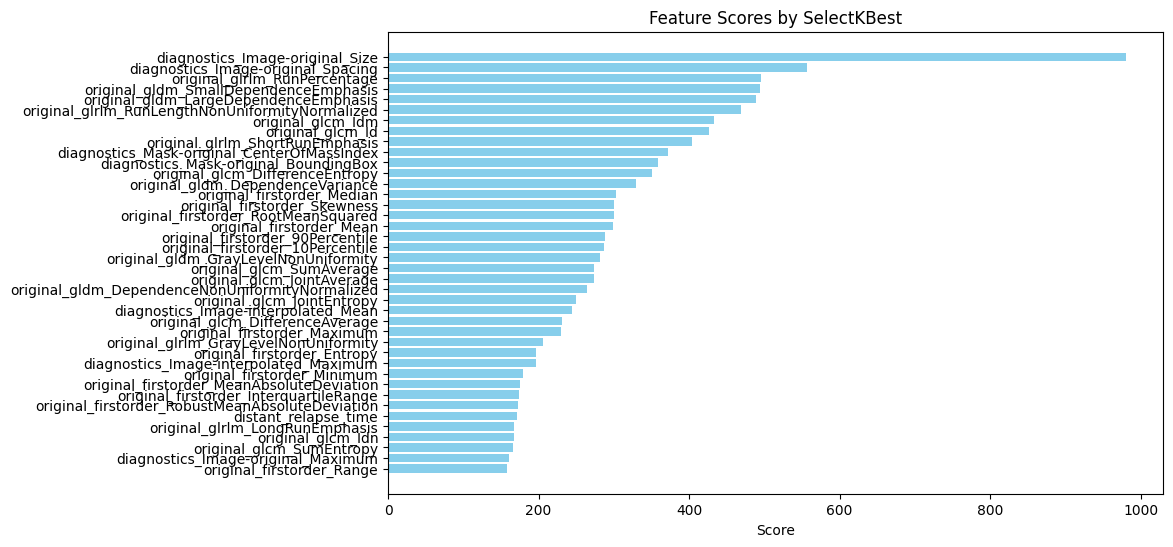

In [10]:
scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

In [11]:
y_train_df = pd.DataFrame(y_train, columns=['classe_name'], dtype='float64')
train_data = pd.concat([X_train_selected_df, y_train_df], axis=1)
y_test_df = pd.DataFrame(y_test, columns=['classe_name'],dtype='float64')
test_data = pd.concat([X_test_selected_df, y_test_df], axis=1)

In [12]:
print(X_train_selected_df.shape)
print(X_test_selected_df.shape)
print(y_train.shape)
print(y_test.shape)
print(train_data.shape)
train_data.head()

(6582, 40)
(2822, 40)
(6582,)
(2822,)
(6582, 41)


,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,...,original_gldm_GrayLevelNonUniformity,original_gldm_LargeDependenceEmphasis,original_gldm_SmallDependenceEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_ShortRunEmphasis,distant_relapse_time,classe_name
1004,1.253818,1.006086,1.093296,0.293866,0.822681,0.493813,1.103066,1.138802,-0.166255,1.208413,...,-0.028030,-1.139058,1.087806,0.816738,-0.705340,1.034298,1.128120,1.097813,-1.276860,0.0
5177,3.340460,2.730630,1.412354,1.373812,2.139718,1.175996,3.006408,3.052411,3.803094,0.682662,...,-0.931935,-1.916007,2.167822,-1.039956,-0.818191,2.169460,1.998518,1.810116,0.044181,1.0
5361,-0.434016,-0.411035,-0.166001,-0.260041,-0.407646,-0.292378,-0.447240,-0.466811,-0.395256,-0.321332,...,1.271651,0.443917,-0.451271,1.358328,0.019472,-0.419246,-0.447812,-0.217778,-0.269955,1.0
2575,-0.076365,-0.281895,-0.811669,-0.542221,-0.409990,-0.584806,-0.196740,-0.190794,0.199056,-0.669721,...,-0.430468,0.855666,-0.829685,-0.606618,0.196531,-0.903419,-0.851187,-0.892310,0.925147,1.0
8311,-0.364050,-0.431035,-0.539283,-0.625830,-0.527164,-0.451272,-0.389223,-0.355731,-0.602448,-0.362505,...,-0.517897,0.393990,-0.406564,-0.619075,-0.052710,-0.387618,-0.399253,-0.180406,-0.107521,2.0


### Baseline Model

Looking at the class imbalance within our target variable 
immediately highlights the issue of using accuracy or R<sup>2</sup> 
as a metric for our model. The dataset we're using is strongly biased towards 
samples where WNV is absent. This means that simply classifing every data point as absent of WNV would <b>net our model an accuracy of almost 95%</b>. 

In this situation, we need a different metric that will help us avoid overfitting to a single class. Using Area Under Curve (AUC) is a great alternative, as it focuses on our sensitivity and specificity of our model. To elaborate, AUC measures how true positive rate (recall) and false positive rate trade off. This reveals how good a model is at distinguishing between positive class and negative class.

Using a AUC Reciever Operating Characteristic or AUC-ROC curve, <b>we can visually compare the true positive and false positive rates at a range of different classification thresholds to identify our best model</b>.

In [13]:
# Baseline
y.value_counts()

classe_name
1.0    5597
2.0    2466
0.0    1341
Name: count, dtype: int64

### Autogluon

In [14]:
autogluon_predictor = TabularPredictor(label='classe_name').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20240606_092405"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240606_092405"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          16
Memory Avail:     

In [30]:
autogluon_predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               XGBoost   1.000000    accuracy       0.007000   2.437733                0.007000           2.437733            1       True         11
1              LightGBM   1.000000    accuracy       0.011001   2.012654                0.011001           2.012654            1       True          5
2   WeightedEnsemble_L2   1.000000    accuracy       0.011995   2.129969                0.000994           0.117314            2       True         14
3         LightGBMLarge   0.996965    accuracy       0.012009   5.426516                0.012009           5.426516            1       True         13
4              CatBoost   0.996965    accuracy       0.014978  11.208119                0.014978          11.208119            1       True          8
5            LightGBMXT   0.9924

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.9332321699544764,
  'KNeighborsDist': 0.9377845220030349,
  'NeuralNetFastAI': 0.9833080424886191,
  'LightGBMXT': 0.992412746585736,
  'LightGBM': 1.0,
  'RandomForestGini': 0.9757207890743551,
  'RandomForestEntr': 0.9772382397572079,
  'CatBoost': 0.9969650986342944,
  'ExtraTreesGini': 0.9696509863429439,
  'ExtraTreesEntr': 0.9681335356600911,
  'XGBoost': 1.0,
  'NeuralNetTorch': 0.9787556904400607,
  'LightGBMLarge': 0.9969650986342944,
  'Weighted

In [16]:
autogluon_predictor.evaluate(test_data,model='WeightedEnsemble_L2')

{'accuracy': 0.9953933380581148,
 'balanced_accuracy': 0.9919970610269119,
 'mcc': 0.9917238842913432}

### Model Preparation

In [17]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'xgb': xgb.XGBClassifier(random_state=42)
        }

In [18]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train_selected, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train_selected, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test_selected)
    y_train_pred = pipe.predict(X_train_selected)
    
    results['model'] = mod
    results['train_accuracy'] = accuracy_score(y_train,y_train_pred)
    results['test_accuracy'] = accuracy_score(y_test,predictions)
    #results['precision'] = precision_score(y_test, predictions)
    #results['recall'] = recall_score(y_test, predictions)
    #results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"train accuracy: {results['train_accuracy']}")
    print(f"test accuracy: {results['test_accuracy']}")
    
    return pipe

## Model Benchmarks 
Here, we're simply running our models with no class adjustments and no hyper-parameter tuning. It's worth noting that <b>without feature engineering, our models performed substantially worse.</b> In iterations without feature engineering our Logistic Regression and AdaBoosting classifiers completely failed to identify any true positives.

In [19]:
lr = run_model('lr')

### METRICS ###


{'model': 'lr',
 'train_accuracy': 0.7324521422060164,
 'test_accuracy': 0.7200566973777462}

train accuracy: 0.7324521422060164
test accuracy: 0.7200566973777462


In [20]:
dt = run_model('dt')

### METRICS ###


{'model': 'dt', 'train_accuracy': 1.0, 'test_accuracy': 0.9815733522324592}

train accuracy: 1.0
test accuracy: 0.9815733522324592


In [21]:
rf = run_model('rf')

### METRICS ###


{'model': 'rf', 'train_accuracy': 1.0, 'test_accuracy': 0.986888731396173}

train accuracy: 1.0
test accuracy: 0.986888731396173


In [22]:
gb = run_model('gb')

### METRICS ###


{'model': 'gb',
 'train_accuracy': 0.9799453053783045,
 'test_accuracy': 0.9649184975194898}

train accuracy: 0.9799453053783045
test accuracy: 0.9649184975194898


In [23]:
et = run_model('et')

### METRICS ###


{'model': 'et', 'train_accuracy': 1.0, 'test_accuracy': 0.9854712969525159}

train accuracy: 1.0
test accuracy: 0.9854712969525159


In [24]:
svc = run_model('svc')

### METRICS ###


{'model': 'svc',
 'train_accuracy': 0.8605287146763901,
 'test_accuracy': 0.8430191353649894}

train accuracy: 0.8605287146763901
test accuracy: 0.8430191353649894


In [25]:
ada = run_model('ada')

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'train_accuracy': 0.8378912184746278,
 'test_accuracy': 0.8451452870304749}

train accuracy: 0.8378912184746278
test accuracy: 0.8451452870304749


In [26]:
xg = run_model('xgb')

### METRICS ###


{'model': 'xgb', 'train_accuracy': 1.0, 'test_accuracy': 0.997165131112686}

train accuracy: 1.0
test accuracy: 0.997165131112686


At this point, it's a bit hard to conclude which is the best classification model. Our Gradient Boosting classfier has the best test AUC scores, but it scores poorly in terms of sensitivity, suggesting that the model isn't good at identifying true positives (i.e. mosquito pools where WNV is present).

Conversely, some of our non-boosting tree classifiers have higher f-scores and are better at predicting true positives, but score poorly in terms of test AUC. This means that our positive and negative populations are overlapping to some degree. This means our model isn't good at predicting WNV - this is also reflected by the high number of positive and negative misclassifications (e.g. our decision tree classifier has the highest number of misclassifications - 246 false positives and 116 false negatives).

In [27]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)

,model,train_accuracy,test_accuracy
0,xgb,1.000000,0.997165
1,rf,1.000000,0.986889
2,et,1.000000,0.985471
3,dt,1.000000,0.981573
4,gb,0.979945,0.964918
5,ada,0.837891,0.845145
6,svc,0.860529,0.843019
7,lr,0.732452,0.720057


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


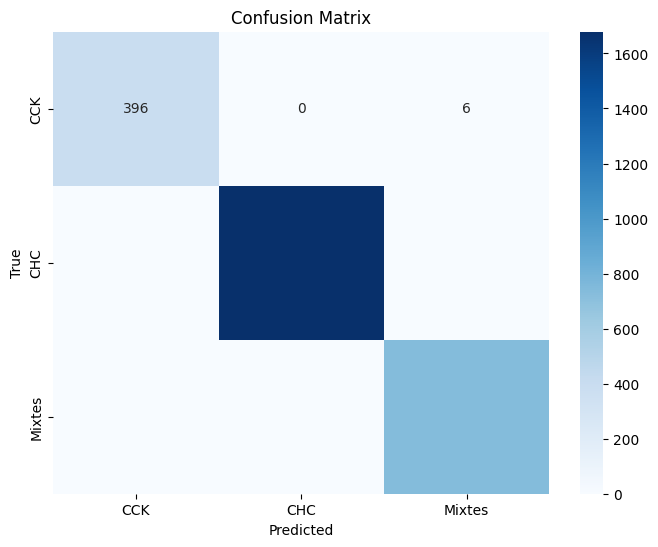

In [28]:
y_pred = xg.predict(X_test_selected_df)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classe_name_mapping.keys(), yticklabels=classe_name_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [29]:
print(classification_report(y_test, y_pred, target_names=classe_name_mapping.keys()))

              precision    recall  f1-score   support

         CCK       1.00      0.99      0.99       402
         CHC       1.00      1.00      1.00      1680
      Mixtes       0.99      1.00      0.99       740

    accuracy                           1.00      2822
   macro avg       1.00      0.99      1.00      2822
weighted avg       1.00      1.00      1.00      2822

